<a href="https://colab.research.google.com/github/Prof-Luis1986/2A_practica01/blob/main/Gestor_de_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial Flet + Firebase (CRUD, PDF, Manejo de Errores)
1. Configuración inicial del proyecto
Antes de empezar, necesitamos instalar las librerías necesarias y configurar nuestro entorno.

Instalación en terminal:

In [ ]:
pip install flet
pip install firebase-admin
pip install reportlab


Estructura de carpetas sugerida:


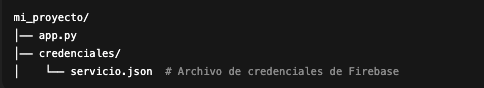


2. Importar librerías y configurar Firebase
Aquí iniciamos nuestro script importando las librerías necesarias y conectándonos a Firebase.

In [ ]:
import flet as ft
import firebase_admin
from firebase_admin import credentials, firestore
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

# Inicializar conexión con Firebase
cred = credentials.Certificate("credenciales/servicio.json")
firebase_admin.initialize_app(cred)
db = firestore.client()


💡 Recuerda que servicio.json lo descargas desde Firebase Console en la sección de configuración del proyecto.



3. Diseño de la Interfaz Principal en Flet
Vamos a crear una ventana principal con un formulario para agregar datos y una tabla para mostrarlos.
Esto será la base de nuestro CRUD.



In [ ]:
def main(page: ft.Page):
    page.title = "CRUD con Flet y Firebase"
    page.theme_mode = ft.ThemeMode.LIGHT
    page.window_width = 900
    page.window_height = 600
    page.scroll = "auto"

    # Campos de entrada
    nombre = ft.TextField(label="Nombre", width=300)
    correo = ft.TextField(label="Correo", width=300)
    telefono = ft.TextField(label="Teléfono", width=300)

    # Tabla para mostrar datos
    tabla = ft.DataTable(
        columns=[
            ft.DataColumn(ft.Text("ID")),
            ft.DataColumn(ft.Text("Nombre")),
            ft.DataColumn(ft.Text("Correo")),
            ft.DataColumn(ft.Text("Teléfono")),
            ft.DataColumn(ft.Text("Acciones"))
        ],
        rows=[]
    )

    # Contenedor principal
    page.add(
        ft.Column(
            controls=[
                ft.Row([nombre, correo, telefono]),
                ft.ElevatedButton("Agregar", icon=ft.icons.ADD, on_click=lambda e: agregar_dato(nombre.value, correo.value, telefono.value, tabla, page)),
                ft.Divider(),
                tabla
            ]
        )
    )

ft.app(target=main)


🔹 Notas importantes:

Estamos definiendo la interfaz y los campos del formulario.

tabla será el componente donde mostraremos los registros obtenidos de Firebase.

agregar_dato() será una función que implementaremos en la siguiente sección para guardar la información.

**4 — Parte 1: Función para agregar un registro a Firebase.**

4.1 Agregar registro a Firebase
En esta parte vamos a:

Tomar los datos del formulario.

Guardarlos en Firebase.

Actualizar la tabla en pantalla.



In [ ]:
# Función para agregar datos a Firebase
def agregar_dato(nombre, correo, telefono, tabla, page):
    if nombre.strip() == "" or correo.strip() == "" or telefono.strip() == "":
        page.snack_bar = ft.SnackBar(ft.Text("Todos los campos son obligatorios"), open=True)
        page.update()
        return

    # Guardar en Firebase
    ref = db.reference("usuarios")
    nuevo_registro = ref.push({
        "nombre": nombre,
        "correo": correo,
        "telefono": telefono
    })

    # Actualizar tabla
    cargar_datos(tabla, page)
    page.snack_bar = ft.SnackBar(ft.Text("Registro agregado correctamente"), open=True)
    page.update()


Código de carga inicial de datos (lo usaremos varias veces):


In [ ]:
# Función para leer datos de Firebase
def cargar_datos(tabla, page):
    ref = db.reference("usuarios")
    datos = ref.get()
    tabla.rows.clear()

    if datos:
        for key, value in datos.items():
            tabla.rows.append(
                ft.DataRow(
                    cells=[
                        ft.DataCell(ft.Text(key)),
                        ft.DataCell(ft.Text(value["nombre"])),
                        ft.DataCell(ft.Text(value["correo"])),
                        ft.DataCell(ft.Text(value["telefono"])),
                        ft.DataCell(ft.Text("Acciones"))  # Editar y Eliminar después
                    ]
                )
            )
    page.update()


🔹 Notas clave:

ref.push() genera un ID único para cada registro.

Usamos cargar_datos() para refrescar la tabla después de agregar.

Más adelante reemplazaremos el texto "Acciones" por botones Editar y Eliminar.

4.2 Eliminar registro de Firebase
Aquí reemplazaremos el texto "Acciones" por botones que permitan eliminar (y más adelante editar).

In [ ]:
def eliminar_dato(id_registro, tabla, page):
    ref = db.reference(f"usuarios/{id_registro}")
    ref.delete()
    cargar_datos(tabla, page)
    page.snack_bar = ft.SnackBar(ft.Text("Registro eliminado"), open=True)
    page.update()


4.3 Editar registro en Firebase
El flujo será:

Llenar los campos del formulario con el registro seleccionado.

Guardar los cambios en Firebase.

Refrescar la tabla.

In [ ]:
def actualizar_dato(id_registro, nombre, correo, telefono, tabla, page):
    if nombre.strip() == "" or correo.strip() == "" or telefono.strip() == "":
        page.snack_bar = ft.SnackBar(ft.Text("Todos los campos son obligatorios"), open=True)
        page.update()
        return

    ref = db.reference(f"usuarios/{id_registro}")
    ref.update({
        "nombre": nombre,
        "correo": correo,
        "telefono": telefono
    })
    cargar_datos(tabla, page)
    page.snack_bar = ft.SnackBar(ft.Text("Registro actualizado"), open=True)
    page.update()


4.4 Botones de acciones en la tabla
Cuando cargamos datos en cargar_datos(), ahora pondremos botones en lugar de texto.

Código modificado de cargar_datos():

In [ ]:
def cargar_datos(tabla, page):
    ref = db.reference("usuarios")
    datos = ref.get()
    tabla.rows.clear()

    if datos:
        for key, value in datos.items():
            tabla.rows.append(
                ft.DataRow(
                    cells=[
                        ft.DataCell(ft.Text(key)),
                        ft.DataCell(ft.Text(value["nombre"])),
                        ft.DataCell(ft.Text(value["correo"])),
                        ft.DataCell(ft.Text(value["telefono"])),
                        ft.DataCell(
                            ft.Row([
                                ft.IconButton(
                                    icon=ft.icons.EDIT,
                                    on_click=lambda e, k=key, v=value: editar_formulario(k, v, page)
                                ),
                                ft.IconButton(
                                    icon=ft.icons.DELETE,
                                    on_click=lambda e, k=key: eliminar_dato(k, tabla, page)
                                )
                            ])
                        )
                    ]
                )
            )
    page.update()


4.5 Función para llenar formulario en modo edición

In [ ]:
# Variables globales
id_edicion = None

def editar_formulario(id_registro, datos, page):
    global id_edicion
    id_edicion = id_registro
    campo_nombre.value = datos["nombre"]
    campo_correo.value = datos["correo"]
    campo_telefono.value = datos["telefono"]
    page.update()


4.6 Botón Guardar/Actualizar dinámico
Cuando el usuario haga clic en Guardar:

Si id_edicion es None → es nuevo registro.

Si tiene valor → actualiza en Firebase.

In [ ]:
def guardar_o_actualizar(e):
    global id_edicion
    if id_edicion:
        actualizar_dato(id_edicion, campo_nombre.value, campo_correo.value, campo_telefono.value, tabla, page)
        id_edicion = None
    else:
        agregar_dato(campo_nombre.value, campo_correo.value, campo_telefono.value, tabla, page)

    # Limpiar formulario
    campo_nombre.value = ""
    campo_correo.value = ""
    campo_telefono.value = ""
    page.update()


4.7 Formulario y tabla final en Flet

In [ ]:
# Campos de entrada
campo_nombre = ft.TextField(label="Nombre")
campo_correo = ft.TextField(label="Correo")
campo_telefono = ft.TextField(label="Teléfono")

# Tabla
tabla = ft.DataTable(
    columns=[
        ft.DataColumn(ft.Text("ID")),
        ft.DataColumn(ft.Text("Nombre")),
        ft.DataColumn(ft.Text("Correo")),
        ft.DataColumn(ft.Text("Teléfono")),
        ft.DataColumn(ft.Text("Acciones")),
    ],
    rows=[]
)

# Botón
btn_guardar = ft.ElevatedButton("Guardar", on_click=guardar_o_actualizar)

# Cargar datos al inicio
cargar_datos(tabla, page)

# Layout
page.add(
    ft.Column([
        campo_nombre,
        campo_correo,
        campo_telefono,
        btn_guardar,
        tabla
    ])
)


✅ Con esto ya tienes:

Crear registros

Listarlos

Editarlos

Eliminarlos

Integración directa con Firebase Realtime Database

Feedback visual con SnackBar.

Código Final:

In [ ]:
import flet as ft
import firebase_admin
from firebase_admin import credentials, firestore
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Image, Spacer, Paragraph
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
import os
import platform
from datetime import datetime

# Configura matplotlib para solo generar imágenes (no abrir ventanas)
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

# Ruta absoluta a tu archivo de credenciales
cred = credentials.Certificate("/Users/luisalfonsomartinezalfaro/Documents/flet_firebase/fb/src/credencial.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

def guardar_grafica_como_imagen(datos, archivo_img="grafica.png"):
    nombres = [d["nombre"] for d in datos]
    calificaciones = [d["calificacion"] for d in datos]
    plt.figure(figsize=(8,4))
    plt.bar(nombres, calificaciones, color='skyblue')
    plt.xlabel("Nombre")
    plt.ylabel("Calificación")
    plt.title("Calificaciones por persona")
    plt.xticks(rotation=45, ha='right')  # <--- Mejora para que no se amontonen los nombres
    plt.tight_layout()
    plt.savefig(archivo_img)
    plt.close()
    return archivo_img

def exportar_pdf(datos):
    archivo = "reporte_datos.pdf"
    doc = SimpleDocTemplate(archivo, pagesize=letter)
    elementos = []

    # Título
    estilos = getSampleStyleSheet()
    elementos.append(Paragraph("Reporte de Datos", estilos['Title']))
    elementos.append(Spacer(1, 12))

    # Tabla de datos
    encabezados = ["Nombre", "Edad", "Género", "Calificación"]
    data_tabla = [encabezados] + [
        [d["nombre"], d["edad"], d["genero"], d["calificacion"]] for d in datos
    ]
    tabla = Table(data_tabla, hAlign='LEFT')
    tabla.setStyle(TableStyle([
        ('BACKGROUND', (0,0), (-1,0), colors.HexColor("#1976D2")),
        ('TEXTCOLOR', (0,0), (-1,0), colors.white),
        ('ALIGN', (0,0), (-1,-1), 'CENTER'),
        ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
        ('FONTSIZE', (0,0), (-1,0), 12),
        ('BOTTOMPADDING', (0,0), (-1,0), 8),
        ('BACKGROUND', (0,1), (-1,-1), colors.whitesmoke),
        ('GRID', (0,0), (-1,-1), 1, colors.grey),
    ]))
    elementos.append(tabla)
    elementos.append(Spacer(1, 24))

    # Gráfica como imagen
    img_file = guardar_grafica_como_imagen(datos)
    elementos.append(Image(img_file, width=400, height=180))

    doc.build(elementos)
    return archivo

def main(page: ft.Page):
    page.title = "Sistema Completo de Análisis de Datos"
    page.scroll = "auto"
    page.bgcolor = ft.Colors.GREY_100

    datos = []
    seleccionado = {"doc_id": None}

    # Elementos de la interfaz
    nombre = ft.TextField(label="Nombre", width=180)
    edad = ft.TextField(label="Edad", width=80, input_filter=ft.NumbersOnlyInputFilter())
    genero = ft.Dropdown(label="Género", width=120, options=[
        ft.dropdown.Option("Femenino"),
        ft.dropdown.Option("Masculino"),
        ft.dropdown.Option("Otro"),
    ])
    calificacion = ft.TextField(label="Calificación (1-10)", width=100, input_filter=ft.NumbersOnlyInputFilter())

    stats = ft.Text("")
    grafica = ft.BarChart(
        bar_groups=[],
        border=ft.border.all(1, ft.Colors.GREY_300),
        left_axis=ft.ChartAxis(labels_size=40),
        bottom_axis=ft.ChartAxis(labels_size=40),
        tooltip_bgcolor=ft.Colors.BLUE,
        width=500,
        height=300,
    )

    tabla = ft.DataTable(
        columns=[
            ft.DataColumn(ft.Text("Nombre")),
            ft.DataColumn(ft.Text("Edad")),
            ft.DataColumn(ft.Text("Género")),
            ft.DataColumn(ft.Text("Calificación")),
            ft.DataColumn(ft.Text("Acciones")),
        ],
        rows=[]
    )

    def limpiar_formulario():
        nombre.value = ""
        edad.value = ""
        genero.value = None
        calificacion.value = ""
        seleccionado["doc_id"] = None

    def leer_datos():
        nonlocal datos
        datos = []
        tabla.rows.clear()
        docs = db.collection('registros').order_by("nombre").stream()  # Ordena por nombre
        for doc in docs:
            d = doc.to_dict()
            d["doc_id"] = doc.id
            tabla.rows.append(
                ft.DataRow([
                    ft.DataCell(ft.Text(str(d.get("nombre", "")))),
                    ft.DataCell(ft.Text(str(d.get("edad", "")))),
                    ft.DataCell(ft.Text(str(d.get("genero", "")))),
                    ft.DataCell(ft.Text(str(d.get("calificacion", "")))),
                    ft.DataCell(
                        ft.Row([
                            ft.IconButton(
                                icon=ft.Icons.EDIT,
                                tooltip="Editar",
                                on_click=lambda e, doc_id=doc.id: cargar_edicion(doc_id)
                            ),
                            ft.IconButton(
                                icon=ft.Icons.DELETE,
                                tooltip="Eliminar",
                                icon_color=ft.Colors.RED,
                                on_click=lambda e, doc_id=doc.id: eliminar_registro(doc_id)
                            ),
                        ])
                    ),
                ])
            )
            datos.append(d)
        actualizar_stats_y_grafica()
        page.update()

    def actualizar_stats_y_grafica():
        if len(datos) == 0:
            stats.value = "No hay datos."
            grafica.bar_groups = []
            return
        edades = [int(d["edad"]) for d in datos if "edad" in d and str(d["edad"]).isdigit()]
        calificaciones = [int(d["calificacion"]) for d in datos if "calificacion" in d and str(d["calificacion"]).isdigit()]
        if calificaciones:
            media = sum(calificaciones) / len(calificaciones)
            varianza = sum((x - media) ** 2 for x in calificaciones) / len(calificaciones)
            moda = max(set(calificaciones), key=calificaciones.count)
        else:
            media = varianza = moda = 0

        stats.value = (
            f"Total de registros: {len(datos)}\n"
            f"Edad promedio: {sum(edades)/len(edades):.2f}\n" if edades else "Edad promedio: N/A\n"
            f"Calificación promedio: {media:.2f}\n"
            f"Varianza de calificaciones: {varianza:.2f}\n"
            f"Moda de calificaciones: {moda}"
        )

        # Gráfica de barras
        bar_groups = []
        for i, d in enumerate(datos):
            if "calificacion" in d and str(d["calificacion"]).isdigit():
                bar_groups.append(
                    ft.BarChartGroup(
                        x=i,
                        bar_rods=[
                            ft.BarChartRod(
                                from_y=0,
                                to_y=int(d["calificacion"]),
                                width=30,
                                color=ft.Colors.BLUE,
                                tooltip=f"{d.get('nombre', '')}: {d.get('calificacion', '')}"
                            )
                        ]
                    )
                )
        grafica.bar_groups = bar_groups

    def agregar_o_modificar(e):
        if not (nombre.value and edad.value and genero.value and calificacion.value):
            page.snack_bar = ft.SnackBar(ft.Text("Completa todos los campos."), open=True)
            page.update()
            return
        nuevo = {
            "nombre": nombre.value,
            "edad": int(edad.value),
            "genero": genero.value,
            "calificacion": int(calificacion.value),
            "fecha": datetime.now().isoformat()
        }
        if seleccionado["doc_id"]:
            db.collection('registros').document(seleccionado["doc_id"]).set(nuevo)
            page.snack_bar = ft.SnackBar(ft.Text("Registro modificado correctamente."), open=True)
        else:
            db.collection('registros').add(nuevo)
            page.snack_bar = ft.SnackBar(ft.Text("Registro agregado correctamente."), open=True)
        limpiar_formulario()
        leer_datos()

    def cargar_edicion(doc_id):
        doc = db.collection('registros').document(doc_id).get()
        if doc.exists:
            d = doc.to_dict()
            nombre.value = d.get("nombre", "")
            edad.value = str(d.get("edad", ""))
            genero.value = d.get("genero", None)
            calificacion.value = str(d.get("calificacion", ""))
            seleccionado["doc_id"] = doc_id
            page.snack_bar = ft.SnackBar(ft.Text("Editando registro."), open=True)
            page.update()

    def eliminar_registro(doc_id):
        db.collection('registros').document(doc_id).delete()
        page.snack_bar = ft.SnackBar(ft.Text("Registro eliminado."), open=True)
        limpiar_formulario()
        leer_datos()

    def exportar_pdf_click(e):
        archivo = exportar_pdf(datos)
        page.snack_bar = ft.SnackBar(ft.Text(f"PDF generado: {archivo}"), open=True)
        page.update()
        # Abrir el PDF automáticamente (solo escritorio)
        if platform.system() == "Darwin":  # macOS
            os.system(f"open {archivo}")
        elif platform.system() == "Windows":
            os.startfile(archivo)
        elif platform.system() == "Linux":
            os.system(f"xdg-open {archivo}")

    # Layout
    page.add(
        ft.Column([
            ft.Text("Sistema Completo de Análisis de Datos", style="headlineMedium", color=ft.Colors.BLUE_900),
            ft.Row([
                nombre, edad, genero, calificacion,
                ft.ElevatedButton("Guardar", icon=ft.Icons.SAVE, on_click=agregar_o_modificar),
                ft.ElevatedButton("Limpiar", icon=ft.Icons.CLEAR, on_click=lambda e: limpiar_formulario()),
                ft.ElevatedButton("Exportar PDF", icon=ft.Icons.PICTURE_AS_PDF, on_click=exportar_pdf_click, bgcolor=ft.Colors.RED_200),
            ], alignment="center"),
            ft.Divider(),
            ft.Text("Datos recolectados", style="titleMedium"),
            tabla,
            ft.Divider(),
            ft.Text("Análisis estadístico", style="titleMedium"),
            stats,
            ft.Divider(),
            ft.Text("Gráfica de calificaciones", style="titleMedium"),
            grafica,
        ], expand=True, horizontal_alignment="center")
    )

    leer_datos()

ft.app(target=main)